## Imbalance Data Handling
Proses ini dilakukan karena model klasifikasi tidak bisa mendeteksi kelas minority dengan baik 

> penyebabnya proporsi data minority dibandingkan data majority 

Hal ini mengakibatkan model cenderung pada data majority. 

Proses handling ini akan dilakukan dengan metode:
- Random Over Sampling
- Random Under Sampling
- SMOTE
- class_weight parameter


Hasil yang diharapkan:

1. mendapatkan metode handling terbaik dengan Evaluation Matrix menggunakan model dasar Decision Tree
1. Membuat perbandingan antar metode. 

selanjutnya hasil imbalancing data akan digunakan guna mendukung model untuk deteksi kelas minority akan diuji dengan ROC-AUC score

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('encoded_train.csv')
df.head()

,Duration,Net Sales,Commision (in value),Age,Claim,Agency_CWT,Agency_EPX,Agency_Others,Agency Type_Travel Agency,Distribution Channel_Online,...,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_URUGUAY,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA,Destination_ZIMBABWE
0,365,216.0,54.0,57.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4,10.0,0.0,33.0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,19,22.0,7.7,26.0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,20,112.0,0.0,59.0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
4,8,16.0,4.0,28.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43832 entries, 0 to 43831
Columns: 151 entries, Duration to Destination_ZIMBABWE
dtypes: float64(3), int64(148)
memory usage: 50.5 MB


In [4]:
# Imbalanced data proportion
(pd.crosstab(index = df['Claim'], columns = 'Proportion (%)',normalize = True)*100).round(2)

col_0,Proportion (%)
Claim,
0,98.46
1,1.54


Terlihat bahwa data imbalance dengan proporsi kelas 0 lebih banyak daripada proporsi kelas 1

In [5]:
non_claim = df[df['Claim'] == 0] ## Majority Class
claim = df[df['Claim'] == 1] ## Minority Class

### Base Decision Tree Modelling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [7]:
X = df.drop(columns = 'Claim')
y = df['Claim']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, stratify = y, random_state = 169)

In [9]:
print(X_train.shape, X_test.shape)

(35065, 150) (8767, 150)


In [10]:
# Decision Tree Model
DT = DecisionTreeClassifier()

In [11]:
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,recall_score,precision_score,f1_score

In [13]:
# Evaluation Matrix
def Eva_Matrix(model,x_train,x_test,y_train,y_test,Nama):
    Model = model.fit(x_train,y_train)
    y_pred_train = Model.predict(x_train)
    acc_train = accuracy_score(y_train,y_pred_train)
    rec_train = recall_score(y_train,y_pred_train)
    prec_train = precision_score(y_train,y_pred_train)
    f1_train = f1_score(y_train,y_pred_train)

    y_pred_test = Model.predict(x_test)
    acc_test = accuracy_score(y_test,y_pred_test)
    rec_test = recall_score(y_test,y_pred_test)
    prec_test = precision_score(y_test,y_pred_test)
    f1_test = f1_score(y_test,y_pred_test)
    
    data_EM = {
    Nama + ' Training':[acc_train,rec_train,prec_train,f1_train],
    Nama + ' Testing':[acc_test,rec_test,prec_test,f1_test]
}

    df_EM = (pd.DataFrame(data_EM,index=['Accuracy','Recall','Precision','F1']).T).round(4)
    cr_train = classification_report(y_train,y_pred_train)
    cm_train = confusion_matrix(y_train,y_pred_train,labels = [1,0])
    df_train = pd.DataFrame(data = cm_train, columns = ['Pred 1','Pred 0'], index = ['Akt 1','Akt 0'])

    cr_test=classification_report(y_test,y_pred_test)
    cm_test=confusion_matrix(y_test,y_pred_test,labels=[1,0])
    df_test=pd.DataFrame(data=cm_test,columns=['Pred 1','Pred 0'],index=['Akt 1','Akt 0'])

    return df_EM ,cr_train, df_train, cr_test, df_test


In [14]:
# Decision Tree Evaluation Matrix function
df_DT, cr_DT_train, cm_DT_train, cr_DT_test, cm_DT_test = Eva_Matrix(DT, X_train, X_test, y_train, y_test, 'Decision Tree Base')

In [15]:
df_DT

,Accuracy,Recall,Precision,F1
Decision Tree Base Training,0.9983,0.8930,1.0000,0.9435
Decision Tree Base Testing,0.9701,0.0667,0.0621,0.0643


In [16]:
print(cr_DT_train, cr_DT_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34523
           1       1.00      0.89      0.94       542

    accuracy                           1.00     35065
   macro avg       1.00      0.95      0.97     35065
weighted avg       1.00      1.00      1.00     35065
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      8632
           1       0.06      0.07      0.06       135

    accuracy                           0.97      8767
   macro avg       0.52      0.53      0.52      8767
weighted avg       0.97      0.97      0.97      8767



Terlihat dari Classification Report terdapat ketimpangan di skor Precision dan Recall antar kelas. 
- Precision kelas 0 dan 1 di Testing memiliki selisih yang besar antara 0.99 dan 0.06
- Recall kelas 0 dan 1 di Testing memiliki selisih yang besar antara 0.98 dan 0.07
- Sehingga data ini perlu proses handling imbalance data

In [17]:
cm_DT_train

,Pred 1,Pred 0
Akt 1,484,58
Akt 0,0,34523


In [18]:
cm_DT_test

,Pred 1,Pred 0
Akt 1,9,126
Akt 0,136,8496


### 1. Random Over Sampling

In [19]:
from sklearn.utils import resample

Membuat duplikasi data kelas minoritas secara random sebanyak data kelas mayoritas

In [20]:
claim_oversample = resample(claim,
                            replace = True,
                            n_samples = len(non_claim),
                            random_state = 169)

In [21]:
df_oversampling = pd.concat([claim_oversample, non_claim])
len(df_oversampling)

86310

In [22]:
df_oversampling['Claim'].value_counts()

1    43155
0    43155
Name: Claim, dtype: int64

Data kelas minoritas sudah diduplikasi sehingga jumlahnya sama dengan data kelas mayoritas. Selanjutnya membuat data train hasil oversampling.

In [23]:
X_train_os = df_oversampling.drop(columns = 'Claim')
y_train_os = df_oversampling['Claim']

In [24]:
df_DT_os, cr_DT_os_train, cm_DT_os_train, cr_DT_os_test, cm_DT_os_test = Eva_Matrix(DT, X_train_os, X_test, y_train_os, y_test,'Decision Tree Over Sample')

In [25]:
print(cr_DT_os_train, cr_DT_os_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43155
           1       1.00      1.00      1.00     43155

    accuracy                           1.00     86310
   macro avg       1.00      1.00      1.00     86310
weighted avg       1.00      1.00      1.00     86310
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8632
           1       0.79      1.00      0.89       135

    accuracy                           1.00      8767
   macro avg       0.90      1.00      0.94      8767
weighted avg       1.00      1.00      1.00      8767



In [26]:
cm_DT_os_train

,Pred 1,Pred 0
Akt 1,43155,0
Akt 0,119,43036


In [27]:
cm_DT_os_test

,Pred 1,Pred 0
Akt 1,135,0
Akt 0,35,8597


Dari Classification Report terlihat bahwa skor Recall kelas 1 di train dan test sama yaitu 1.00. Hal ini menandakan bahwa model menghafal/overfit terutama di kelas 1.

### 2. Random Under Sampling
mereduksi data kelas mayoritas sehingga jumlahnya sama dengan data kelas minoritas

In [28]:
claim_undersample = resample(non_claim,
                            replace = True,
                            n_samples = len(claim),
                            random_state = 169)

In [29]:
df_undersampling = pd.concat([claim_undersample, claim])

In [30]:
df_undersampling['Claim'].value_counts()

0    677
1    677
Name: Claim, dtype: int64

Data kelas minoritas dan mayoritas sudah sama, lalu dijadikan data train set baru.

In [31]:
X_train_us = df_undersampling.drop(columns = 'Claim')
y_train_us = df_undersampling['Claim']

In [32]:
df_DT_us, cr_DT_us_train, cm_DT_us_train, cr_DT_us_test, cm_DT_us_test = Eva_Matrix(DT, X_train_us, X_test, y_train_us, y_test, 'Decision Tree Under Sample')

In [33]:
print(cr_DT_us_train, cr_DT_us_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       677
           1       1.00      0.99      1.00       677

    accuracy                           1.00      1354
   macro avg       1.00      1.00      1.00      1354
weighted avg       1.00      1.00      1.00      1354
               precision    recall  f1-score   support

           0       1.00      0.70      0.82      8632
           1       0.05      0.99      0.09       135

    accuracy                           0.70      8767
   macro avg       0.52      0.84      0.46      8767
weighted avg       0.99      0.70      0.81      8767



In [34]:
cm_DT_us_train

,Pred 1,Pred 0
Akt 1,672,5
Akt 0,1,676


In [35]:
cm_DT_us_test

,Pred 1,Pred 0
Akt 1,134,1
Akt 0,2626,6006


Dari classification report terlihat bahwa model dapat mendeteksi kelas minoritas namun testing menunjukkan model tidak bisa mendeteksi kelas mayoritas. Di confusion matrix false negative berkurang sedikit namun false positif melonjak sanget tinggi.

## 3. Random Sampling
merupakan metode yang menduplikasi data kelas minoritas sekaligus mereduksi data kelas mayoritas dengan jumlah akhir yang sama.

In [36]:
claim_oversample = resample(claim,
                            replace = True,
                            n_samples = 12000,
                            random_state = 169)
claim_undersample = resample(non_claim,
                            replace = True,
                            n_samples = 12000,
                            random_state = 169)

In [37]:
df_rs = pd.concat([claim_oversample, claim_undersample])

In [38]:
df_rs['Claim'].value_counts()

1    12000
0    12000
Name: Claim, dtype: int64

Data kelas mayoritas sudah sama jumlah dengan kelas minoritas lalu akan dibuat data train set.

In [39]:
X_train_rs = df_rs.drop(columns = 'Claim')
y_train_rs = df_rs['Claim']

In [40]:
df_DT_rs, cr_DT_rs_train, cm_DT_rs_train, cr_DT_rs_test, cm_DT_rs_test = Eva_Matrix(DT, X_train_rs, X_test, y_train_rs, y_test, 'Decision Tree Random Sample')

In [41]:
print(cr_DT_rs_train, cr_DT_rs_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12000
           1       1.00      1.00      1.00     12000

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8632
           1       0.63      1.00      0.77       135

    accuracy                           0.99      8767
   macro avg       0.81      1.00      0.88      8767
weighted avg       0.99      0.99      0.99      8767



In [42]:
cm_DT_rs_train

,Pred 1,Pred 0
Akt 1,12000,0
Akt 0,44,11956


In [43]:
cm_DT_rs_test

,Pred 1,Pred 0
Akt 1,135,0
Akt 0,80,8552


Dari confusion matrix, terlihat bahwa model saat train mampu mendeteksi kelas minoritas tapi saat test banyak error yaitu False Negative yang semakin besar

### 4. SMOTE

In [44]:
import imblearn
from imblearn.over_sampling import SMOTE

In [45]:
sm = SMOTE(random_state = 169)

In [46]:
# Splitting data
from sklearn.model_selection import train_test_split

In [47]:
X = df.drop(columns = 'Claim')
y = df['Claim']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, stratify = y, random_state = 42)

In [49]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [50]:
df_SMOTE = pd.concat([X_train_sm, y_train_sm], axis = 1)
df_SMOTE['Claim'].value_counts()

0    34523
1    34523
Name: Claim, dtype: int64

In [51]:
X_train_sm = df_SMOTE.drop(columns = 'Claim')
y_train_sm = df_SMOTE['Claim']

In [52]:
df_DT_sm, cr_DT_sm_train, cm_DT_sm_train, cr_DT_sm_test, cm_DT_sm_test = Eva_Matrix(DT, X_train_sm, X_test, y_train_sm, y_test, 'Decision Tree SMOTE')


In [53]:
print(cr_DT_sm_train, cr_DT_sm_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34523
           1       1.00      1.00      1.00     34523

    accuracy                           1.00     69046
   macro avg       1.00      1.00      1.00     69046
weighted avg       1.00      1.00      1.00     69046
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      8632
           1       0.05      0.10      0.07       135

    accuracy                           0.96      8767
   macro avg       0.52      0.53      0.52      8767
weighted avg       0.97      0.96      0.97      8767



In [54]:
cm_DT_sm_train

,Pred 1,Pred 0
Akt 1,34461,62
Akt 0,11,34512


In [55]:
cm_DT_sm_test

,Pred 1,Pred 0
Akt 1,13,122
Akt 0,231,8401


Dari Classification report terlihat bahwa model mendapat skor bagus di train tapi di test sangat jauh. Metode ini tidak cocok dalam kasus ini

### Class Weight Parameter
metode ini memberikan parameter class_weight di dalam model sehingga model akan lebih memprioritaskan train di kelas minoritas

In [56]:
DT_CW = DecisionTreeClassifier(class_weight = {0 : .10,
                                               1 : .90})

In [57]:
df_DT_CW, cr_DT_CW_train, cm_DT_CW_train, cr_DT_CW_test, cm_DT_CW_test = Eva_Matrix(DT_CW, X_train, X_test, y_train, y_test, "Decision Tree Class Weight")

In [58]:
print(cr_DT_CW_train, cr_DT_CW_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34523
           1       0.87      1.00      0.93       542

    accuracy                           1.00     35065
   macro avg       0.94      1.00      0.97     35065
weighted avg       1.00      1.00      1.00     35065
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      8632
           1       0.06      0.07      0.06       135

    accuracy                           0.97      8767
   macro avg       0.52      0.52      0.52      8767
weighted avg       0.97      0.97      0.97      8767



In [59]:
cm_DT_CW_train

,Pred 1,Pred 0
Akt 1,542,0
Akt 0,79,34444


In [60]:
cm_DT_CW_test

,Pred 1,Pred 0
Akt 1,9,126
Akt 0,151,8481


Terlihat dari hasil Confusion Matrix bahwa model tidak mendeteksi kelas minoritas dengan baik sehingga errornya lebih besar dari train (False Negative dan False Positive bertambah)

## Model Tuning
untuk mendapatkan parameter terbaik dalam mengatasi overfitting

In [61]:
# Gridsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [62]:
skf = StratifiedKFold(n_splits = 5)

In [63]:
params = {'max_leaf_nodes': list(range(2, 70)),
            'min_samples_split': range(2, 5),
            'max_depth' : range(1, 8)}

Sebelumnya sudah mencoba dengan GridSearchCV, namun memakan waktu terlalu lama sehingga laptop overheat

Kemudian diputuskan untuk menggunakan RandomizedSearchCV karena hasil tidak jauh berbeda dengan GridSearchCV serta proses executing lebih cepat

Hal ini dilakukan guna untuk mencari parameter tree terbaik dengan data train menggunakan data train hasil metode random oversampling

In [64]:

DT_RS = RandomizedSearchCV(DecisionTreeClassifier(random_state = 169), param_distributions = params, verbose = 1, cv = skf, n_jobs = -1, n_iter = 30, scoring = 'f1')
DT_RS.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=169),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 8),
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31, ...],
                                        'min_samples_split': range(2, 5)},
                   scoring='f1', verbose=1)

In [65]:
print(DT_RS.best_estimator_, DT_RS.best_score_)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=65, random_state=169) 0.8056608839583669


In [66]:
best_model = DT_RS.best_estimator_
best_model.fit(X_train_os, y_train_os)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=65, random_state=169)

Didapatkan dari hasil RandomizedSearchCV bahwa tree terbaik dengan max_depth = 7, max_leaf_nodes = 65 dan model hasil tuning disimpan dalam variabel best_model

In [67]:
df_DT_Tuned_os, cr_DT_Tuned_os_train, cm_DT_Tuned_os_train, cr_DT_Tuned_os_test, cm_DT_Tuned_os_test = Eva_Matrix(best_model, X_train_os, X_test, y_train_os, y_test, 'Decision Tree Tuned OverSample')

In [68]:
print(cr_DT_Tuned_os_train, cr_DT_Tuned_os_test)

              precision    recall  f1-score   support

           0       0.84      0.76      0.79     43155
           1       0.78      0.85      0.81     43155

    accuracy                           0.80     86310
   macro avg       0.81      0.80      0.80     86310
weighted avg       0.81      0.80      0.80     86310
               precision    recall  f1-score   support

           0       1.00      0.76      0.87      8632
           1       0.05      0.81      0.10       135

    accuracy                           0.77      8767
   macro avg       0.52      0.79      0.48      8767
weighted avg       0.98      0.77      0.85      8767



In [69]:
cm_DT_Tuned_os_train

,Pred 1,Pred 0
Akt 1,36886,6269
Akt 0,10571,32584


In [70]:
cm_DT_Tuned_os_test

,Pred 1,Pred 0
Akt 1,110,25
Akt 0,2030,6602


In [71]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.76      0.87      8632
           1       0.05      0.81      0.10       135

    accuracy                           0.77      8767
   macro avg       0.52      0.79      0.48      8767
weighted avg       0.98      0.77      0.85      8767



Dari hasil tuning, overfitting model berkurang dari sebelum tuning Recall kelas 1 train dan test adalah 1.00 sedangkan setelah tuning menjadi stabil di 0.69 dan Precision kelas 0 yang stabil dari 0.73 ke 0.99.

## Save Model to Pickle extension

In [72]:
import pickle
pickle.dump(best_model, open('ClaimDetector_DecisionTree_v.1.0.pkl', 'wb'))

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve


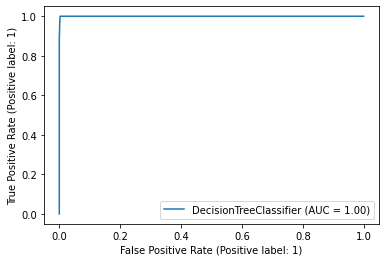

In [74]:
plot_roc_curve(DT, X_train, y_train)

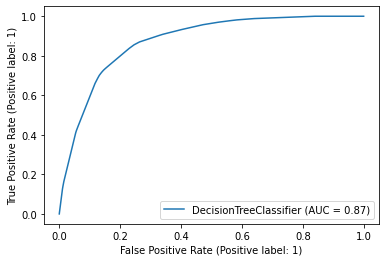

In [78]:
plot_roc_curve(best_model, X_train_os, y_train_os)

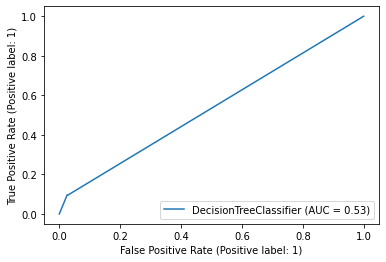

In [80]:
plot_roc_curve(DT, X_test, y_test)

In [81]:
y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8632
           1       0.05      0.10      0.07       135

    accuracy                           0.96      8767
   macro avg       0.52      0.53      0.52      8767
weighted avg       0.97      0.96      0.97      8767



In [82]:
y_pred_1 = best_model.predict(X_test)
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       1.00      0.76      0.87      8632
           1       0.05      0.81      0.10       135

    accuracy                           0.77      8767
   macro avg       0.52      0.79      0.48      8767
weighted avg       0.98      0.77      0.85      8767



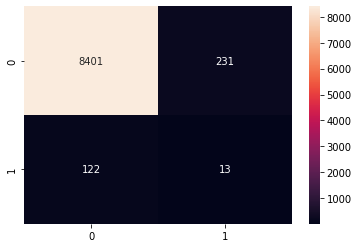

In [83]:
# confusion matrix benchmark model (base Decision Tree)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.4g');

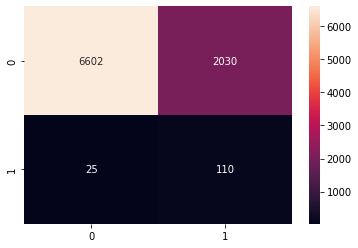

In [84]:
# confusion matrix after tuning
sns.heatmap(confusion_matrix(y_test, y_pred_1), annot=True, fmt='.4g');

Terlihat bahwa FN turun sangat besar before 122 after 25

## Kesimpulan

1. Berdasarkan data, Cancellation Plan adalah most selling produk dengan tingkat claim rendah
1. Berdasarkan data, Bronze Plan adalah produk dengan claim rate tertinggi, diikuti Annual Silver Plan, dan Silver Plan dibanding insurance plan yang lain 
1. Hypertuning RandomizedSearchCV terhadap model Decision Tree Classifier mampu memperkecil FN dibandingkan Benchmark




## Rekomendasi

1. Memfokuskan penjualan asuransi pada produk Cancellation Plan( guna mensiasati kenaikan revenue perusahaan karena sedikit yang claim)
1. Meningkatkan premi produk agar cash flow lebih besar (guna subsidi tingkat claim yang cukup tinggi)
1. Menambahkan fitur lain agar dapat lebih optimal (contoh terhadap netsales yang memiliki nilai negative) serta mencoba algoritma ML lain dan alternative pendekatan bisnis dengan menggunakan matrix lain
